In [17]:
import time 

import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as trans

In [18]:
fc =nn.Linear(500,300)
paras = fc.parameters()

print(paras)
paras = list(paras)
print(paras)


<generator object Module.parameters at 0x123913d80>
[Parameter containing:
tensor([[ 0.0009, -0.0345,  0.0052,  ...,  0.0257,  0.0057, -0.0162],
        [-0.0345,  0.0053, -0.0385,  ..., -0.0165,  0.0083, -0.0004],
        [-0.0022, -0.0131, -0.0277,  ..., -0.0255, -0.0019,  0.0095],
        ...,
        [-0.0402,  0.0126,  0.0201,  ...,  0.0067,  0.0301, -0.0372],
        [ 0.0123, -0.0348,  0.0151,  ...,  0.0012,  0.0158, -0.0224],
        [-0.0078,  0.0372, -0.0159,  ...,  0.0391, -0.0136,  0.0325]],
       requires_grad=True), Parameter containing:
tensor([-0.0155,  0.0327, -0.0139,  0.0152,  0.0132,  0.0254,  0.0143, -0.0190,
         0.0387, -0.0139, -0.0210, -0.0204, -0.0178,  0.0048,  0.0372,  0.0011,
         0.0083, -0.0373,  0.0176,  0.0066, -0.0262, -0.0412,  0.0389,  0.0338,
         0.0128,  0.0052, -0.0365,  0.0167, -0.0060, -0.0418, -0.0355,  0.0412,
        -0.0130, -0.0350, -0.0256,  0.0131, -0.0127, -0.0191,  0.0150, -0.0068,
        -0.0044, -0.0207,  0.0289, -0.027

In [19]:
class SGD:
    def __init__(self,parameters,lr,momentum=0.0):
        # super(SGD,self).__init__()
        self.x_state = list(parameters)
        self.lr = lr
        self.momentum = momentum
        self.v_state = [t.data.clone().zero_() for t in self.x_state]
    
    def zero_grad(self):
        for x in self.x_state:
            if x.grad is not None:
                x.grad.data.zero_()
    
    def step(self):
        for x,v in zip(self.x_state,self.v_state):
            g = x.grad.data
            v.mul_(self.momentum).add_(g) # v = v*momentum + g
            x.data.add_(-self.lr,v) # x = x - lr*v

In [20]:
import torch
batch_size = 100

train_set = dsets.MNIST(root='../data/mnist/',
                        transform=trans.ToTensor(),
                        train=True)
test_set = dsets.MNIST(root='../data/mnist/',
                       transform=trans.ToTensor(),
                          train=False)
train_dl = torch.utils.data.DataLoader(dataset=train_set,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=6)
test_dl = torch.utils.data.DataLoader(dataset=test_set,
                                        batch_size=batch_size,
                                        num_workers=6)


定义模型

In [21]:
import torch

# 检查 MPS 的可用性，如果可用则选择 MPS，否则选择 CPU
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: mps


In [22]:
model = nn.Sequential(nn.Linear(784, 500),nn.ReLU(),
                        nn.Linear(500, 300),nn.ReLU(),
                        nn.Linear(300, 10)).to(device)

critertion = nn.CrossEntropyLoss()
# optimizer = SGD(model.parameters(),lr=0.1)

                      

辅助函数

In [23]:
def eval(model,criterion,dataloader):
    loss,accuracy = 0,0
    for batch_x,batch_y in dataloader:
        batch_x = batch_x.view(-1,784)
        batch_x,batch_y = batch_x.to(device),batch_y.to(device)
        
        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.item()
        
        probs,pred_y = logits.data.max(dim=1)
        accuracy += (pred_y==batch_y.data).sum().float()/batch_y.size(0)
        
    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss,accuracy

In [24]:
sgd = SGD(model.parameters(),lr=0.1,momentum=0.9)
nepochs = 30

# 记录学习过程
learn_history = []
# 训练
for epoch in range(nepochs):
    since = time.time()
    total = 0
    for batch_x,batch_y in train_dl:
        batch_x = batch_x.view(-1,784)
        batch_x,batch_y = batch_x.to(device),batch_y.to(device)
        
        sgd.zero_grad()
        logits = model(batch_x)
        error = critertion(logits,batch_y)
        error.backward()
        sgd.step()
        
  
    tr_loss,tr_acc = eval(model,critertion,train_dl)
    te_loss,te_acc = eval(model,critertion,test_dl)
    now = time.time()
    print('[%3d/%d, %.f seconds] |\t train error: %.1e, train acc: %.2f|\t test error: %.1e, test acc: %.2f'%(
        epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc)
    )
    learn_history.append([tr_loss,tr_acc,te_loss,te_acc])
        

[  1/30, 11 seconds] |	 train error: 1.1e-01, train acc: 96.79|	 test error: 1.2e-01, test acc: 96.35
[  2/30, 11 seconds] |	 train error: 5.7e-02, train acc: 98.26|	 test error: 8.5e-02, test acc: 97.23
[  3/30, 10 seconds] |	 train error: 4.6e-02, train acc: 98.50|	 test error: 8.1e-02, test acc: 97.45
[  4/30, 11 seconds] |	 train error: 3.4e-02, train acc: 99.00|	 test error: 7.1e-02, test acc: 97.77
[  5/30, 10 seconds] |	 train error: 2.3e-02, train acc: 99.25|	 test error: 6.6e-02, test acc: 98.14
[  6/30, 10 seconds] |	 train error: 1.9e-02, train acc: 99.40|	 test error: 6.6e-02, test acc: 97.99
[  7/30, 10 seconds] |	 train error: 1.8e-02, train acc: 99.40|	 test error: 7.1e-02, test acc: 97.94
[  8/30, 10 seconds] |	 train error: 1.7e-02, train acc: 99.46|	 test error: 9.1e-02, test acc: 97.64
[  9/30, 11 seconds] |	 train error: 1.3e-02, train acc: 99.59|	 test error: 8.1e-02, test acc: 97.78
[ 10/30, 11 seconds] |	 train error: 4.3e-03, train acc: 99.88|	 test error: 7.9e-

In [25]:
[t[1] for t in learn_history]

[tensor(96.7934, device='mps:0'),
 tensor(98.2632, device='mps:0'),
 tensor(98.4999, device='mps:0'),
 tensor(99.0014, device='mps:0'),
 tensor(99.2499, device='mps:0'),
 tensor(99.3966, device='mps:0'),
 tensor(99.4032, device='mps:0'),
 tensor(99.4615, device='mps:0'),
 tensor(99.5899, device='mps:0'),
 tensor(99.8800, device='mps:0'),
 tensor(99.7599, device='mps:0'),
 tensor(99.6916, device='mps:0'),
 tensor(99.8550, device='mps:0'),
 tensor(99.8733, device='mps:0'),
 tensor(99.7382, device='mps:0'),
 tensor(99.7916, device='mps:0'),
 tensor(99.7966, device='mps:0'),
 tensor(99.7833, device='mps:0'),
 tensor(99.8249, device='mps:0'),
 tensor(99.9066, device='mps:0'),
 tensor(99.9400, device='mps:0'),
 tensor(99.9350, device='mps:0'),
 tensor(99.6733, device='mps:0'),
 tensor(99.7766, device='mps:0'),
 tensor(99.9516, device='mps:0'),
 tensor(99.9200, device='mps:0'),
 tensor(100., device='mps:0'),
 tensor(100., device='mps:0'),
 tensor(100., device='mps:0'),
 tensor(100., device='m

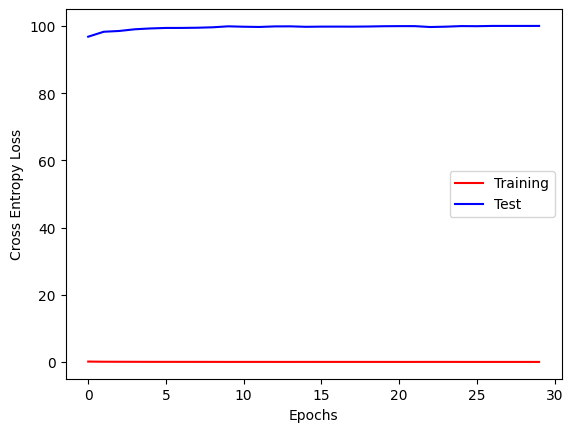

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([t[0] for t in learn_history],'r',label='Training')
plt.plot([t[1].cpu() for t in learn_history],'b',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()


In [44]:
import time 
import math

import torch 
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as trans 

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

实现Adam算法的优化器

In [60]:
class Adam:
    def __init__(self,paras,lr,beta1=0.9, beta2=0.999,eps=1e-8):

        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.nsteps = 0
        
        
        self.x_state = list(paras)
        self.m_state = [t.data.clone().zero_() for t in self.x_state]
        self.v_state = [t.data.clone().zero_() for t in self.x_state]

    def zero_grad(self):
        for x in self.x_state:
            if x.grad is not None:
                x.grad.detach_()
                x.grad.data.zero_()
                
    def step(self):
        self.nsteps += 1
        for x,m,v in zip(self.x_state,self.m_state,self.v_state):
            if x.grad is None:
                continue
            g = x.grad.data
            m.mul_(self.beta1).add_(g, alpha=1-self.beta1)
            v.mul_(self.beta2).addcmul_(g,g,value=1-self.beta2)
            m_bias = m/(1-self.beta1**self.nsteps)
            v_bias = v/(1-self.beta2**self.nsteps)
            x.data.addcdiv_(m_bias,v_bias.sqrt().add_(self.eps),value=-self.lr)
            

准备数据和网络

In [61]:
BATCH_SIZE = 100
train_set = dsets.MNIST(root='../data/mnist/',
                        transform=trans.ToTensor(),
                        train=True)
test_set = dsets.MNIST(root='../data/mnist/',
                       transform=trans.ToTensor(),
                            train=False)
train_dl = torch.utils.data.DataLoader(dataset=train_set,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=6)
test_dl = torch.utils.data.DataLoader(dataset=test_set,
                                        batch_size=BATCH_SIZE,
                                        num_workers=6)

辅助函数

In [62]:
def eval(model, criterion, dataloader):
    loss, accuracy = 0, 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.view(-1, 784)
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        logits = model(batch_x)
        error = criterion(logits, batch_y)
        loss += error.item()

        probs, pred_y = logits.data.max(dim=1)
        accuracy += (pred_y == batch_y.data).sum().float() / batch_y.size(0)

    loss /= len(dataloader)
    accuracy = accuracy * 100.0 / len(dataloader)
    return loss, accuracy


训练

In [63]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(weights_init)

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=10, bias=True)
)

In [64]:
model = nn.Sequential(nn.Linear(784, 500), nn.ReLU(),
                        nn.Linear(500, 300), nn.ReLU(),
                        nn.Linear(300, 10)).to(device)
# 损失函数
criterion = nn.CrossEntropyLoss()
# 优化器
optimizer = Adam(model.parameters(), lr=0.001)

#记录
learn_history = []
# 训练
for epoch in range(20):
    for batch_x, batch_y in train_dl:
        batch_x = batch_x.view(-1, 784)
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)
        error = criterion(logits, batch_y)
        error.backward()
        optimizer.step()
        
    tr_loss, tr_acc = eval(model, criterion, train_dl)
    te_loss, te_acc = eval(model, criterion, test_dl)
    print('[%d/%d] train error: %.2e, train acc: %.2f \t test error: %.2e, test acc: %.2f' % (
        epoch + 1, 20, tr_loss, tr_acc, te_loss, te_acc))
    learn_history.append([tr_loss, tr_acc, te_loss, te_acc])

[1/20] train error: 1.14e-01, train acc: 96.53 	 test error: 1.24e-01, test acc: 96.04
[2/20] train error: 5.96e-02, train acc: 98.23 	 test error: 8.74e-02, test acc: 97.35
[3/20] train error: 5.86e-02, train acc: 98.18 	 test error: 9.59e-02, test acc: 96.94
[4/20] train error: 3.15e-02, train acc: 98.97 	 test error: 8.15e-02, test acc: 97.53
[5/20] train error: 2.15e-02, train acc: 99.27 	 test error: 7.08e-02, test acc: 97.83
[6/20] train error: 2.85e-02, train acc: 99.02 	 test error: 8.73e-02, test acc: 97.56
[7/20] train error: 2.18e-02, train acc: 99.35 	 test error: 8.94e-02, test acc: 97.67
[8/20] train error: 2.03e-02, train acc: 99.30 	 test error: 9.56e-02, test acc: 97.51
[9/20] train error: 1.38e-02, train acc: 99.56 	 test error: 9.04e-02, test acc: 97.93
[10/20] train error: 1.30e-02, train acc: 99.58 	 test error: 9.41e-02, test acc: 97.96
[11/20] train error: 1.17e-02, train acc: 99.61 	 test error: 7.97e-02, test acc: 98.09
[12/20] train error: 1.70e-02, train acc:

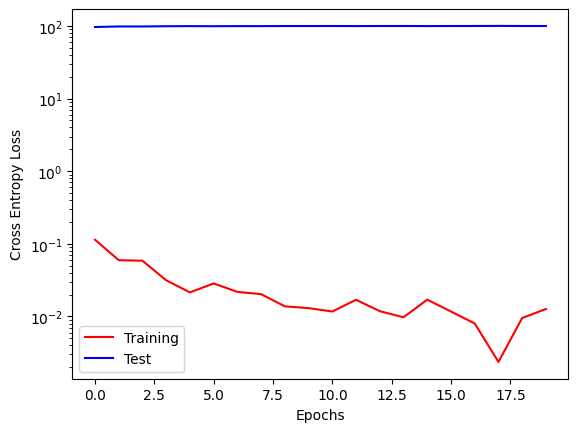

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.semilogy([t[0] for t in learn_history],'r',label='Training')
plt.semilogy([t[1].cpu() for t in learn_history],'b',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()